# EDA For Predictive Maintenance Beta
## Griffin Brown
### 8/22/2022

This notebook serves as the EDA for a predictive maintenance beta (for capstone) project. The dataset comes from kaggle.

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('predictive_maintenance.csv')

df.shape

(10000, 10)

In [55]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [56]:
missing_values = df.isna().sum()

missing_values

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

A dream. This makes pretty good sense to me given that this would be sensor data, and the only way to lose data would be after a failure. But to be sure lets impute any possible "blanks."

In [57]:
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

missing_values = df.isna().sum()

missing_values

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [74]:
df['Target'].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

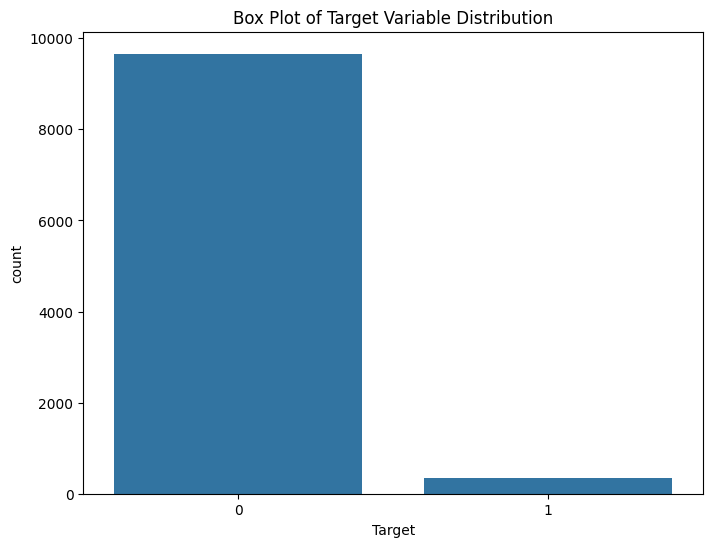

In [73]:
plt.figure(figsize=(8,6))
sns.countplot(x=df['Target'])
plt.title('Box Plot of Target Variable Distribution')
plt.show()

Very heavily skewed towards no-failure. Let's make sure Product ID is specific to every row.

In [58]:
len(df['Product ID'].unique())

10000

The same goes for UDI, as I'm not sure that this variable is unqiue to every row or there are multiple rows in the data per ID.

In [75]:
len(df['UDI'].unique())

10000

Lets explore some numeric columns.

In [59]:
num_col = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]

cat_col = df[['Type', 'Failure Type']]

array([[<AxesSubplot: title={'center': 'Air temperature [K]'}>,
        <AxesSubplot: title={'center': 'Process temperature [K]'}>],
       [<AxesSubplot: title={'center': 'Rotational speed [rpm]'}>,
        <AxesSubplot: title={'center': 'Torque [Nm]'}>],
       [<AxesSubplot: title={'center': 'Tool wear [min]'}>,
        <AxesSubplot: >]], dtype=object)

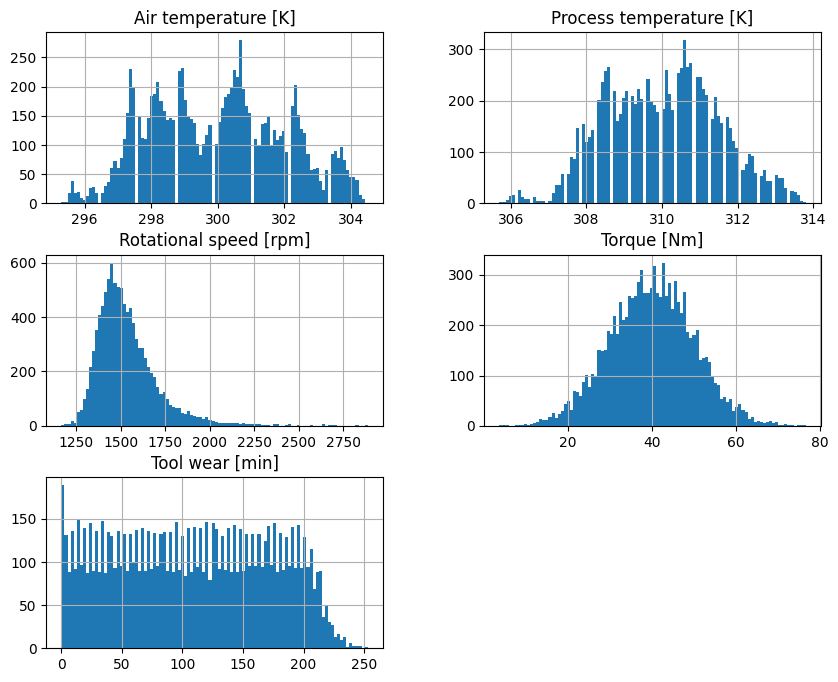

In [60]:
num_col.hist(figsize=(10,8), bins=100)

Given the distribution of some of these, my naive guess is that Torque might be a leading cause for failure just because of it's heavy skew.

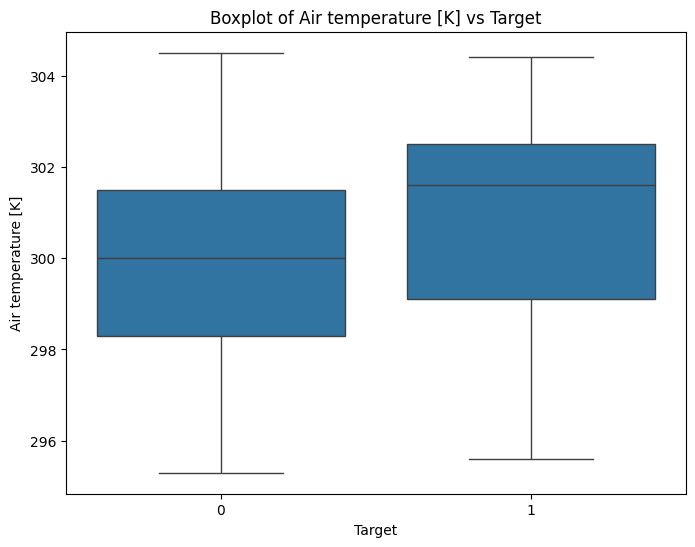

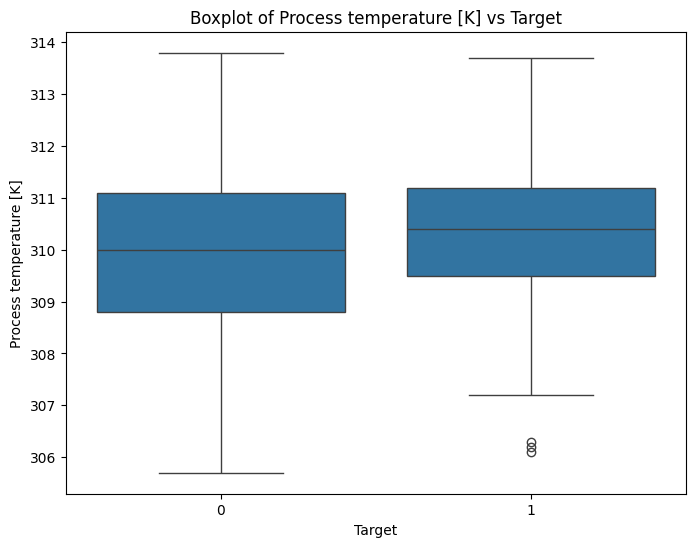

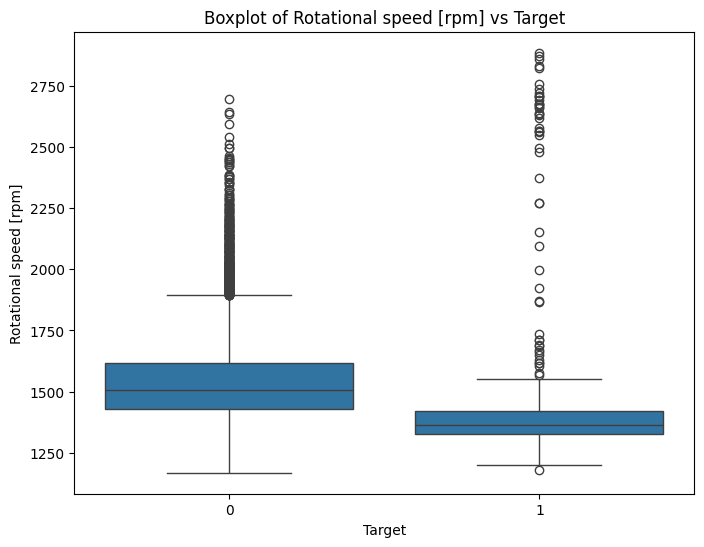

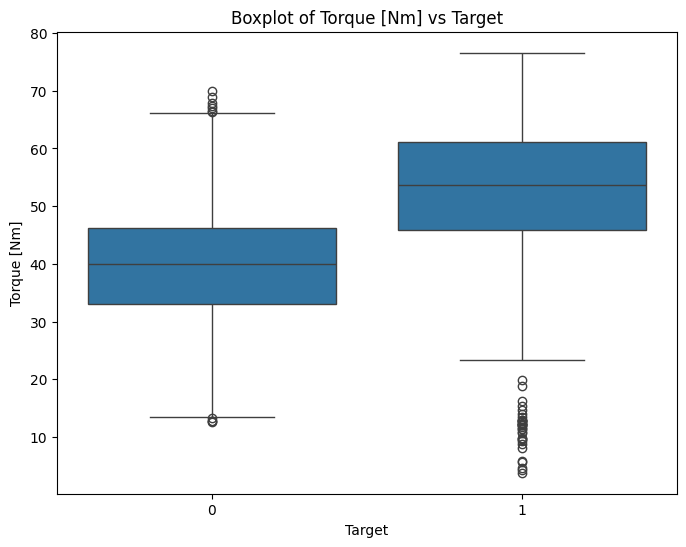

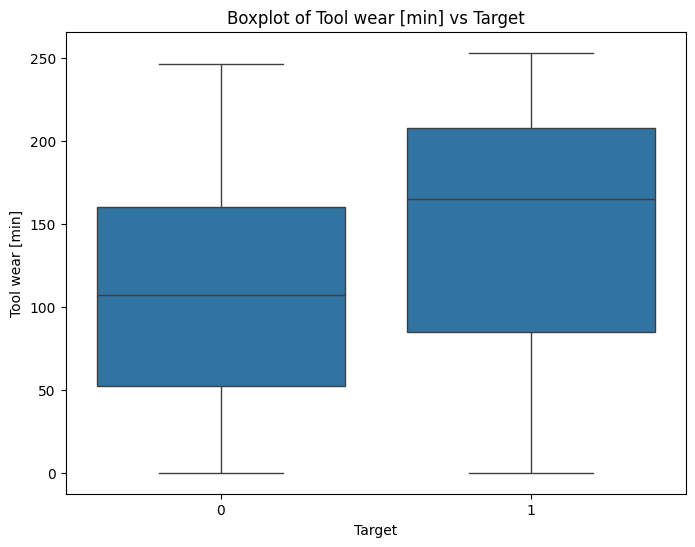

In [61]:
for col in num_col:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='Target', y=col)
    plt.title(f'Boxplot of {col} vs Target')
    plt.show()

Torque seems to have the biggest discrepancy.

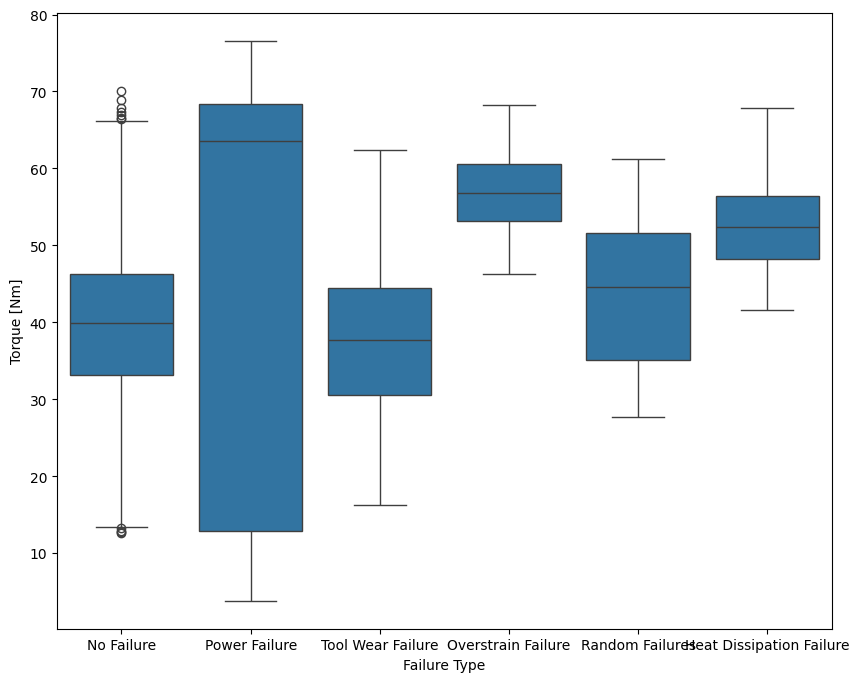

In [62]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='Failure Type', y='Torque [Nm]')
plt.show()

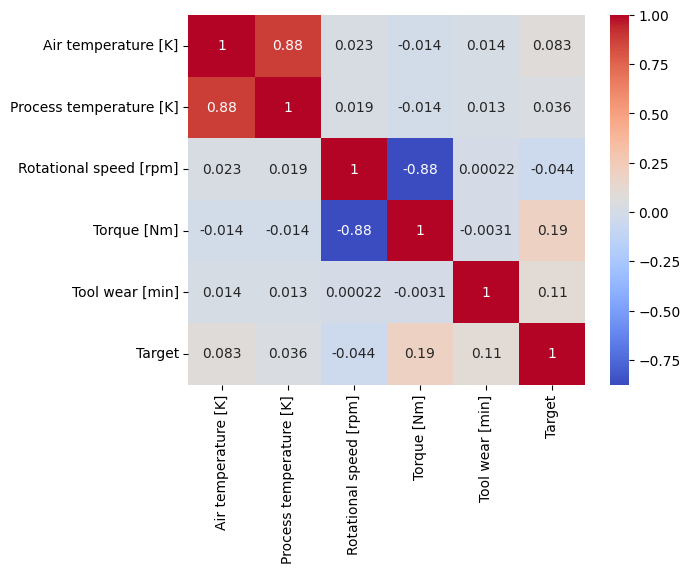

In [63]:
num_corr_matrix = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target']].corr()
sns.heatmap(num_corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Nothing seems to be jumping out as colinear with the target.

Lets check some categorical columns.

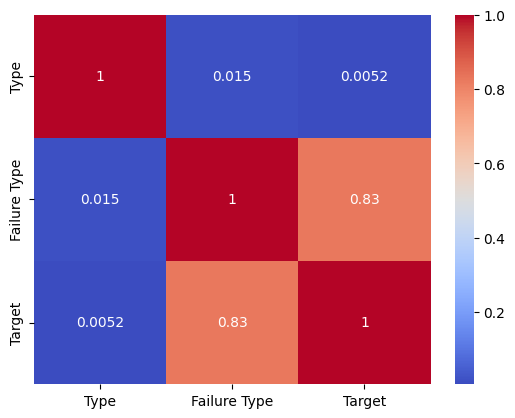

In [67]:
cat_df = df.copy()
cat_df['Type'] = pd.factorize(cat_df['Type'])[0]
cat_df['Failure Type'] = pd.factorize(cat_df['Failure Type'])[0]

cat_corr_matrix = cat_df[['Type', 'Failure Type', 'Target']].corr()
sns.heatmap(cat_corr_matrix, annot=True, cmap='coolwarm')
plt.show()

There's a strong correlation with Failure Type and Target, so I want to be weary of that. My guess is, given by how the data is structured, every time the Target is '0' the Failure Type is 'No Failure', so this essentially duplicates the target column. It's also logical to think that you only know how a product fails after it has failed, not before.

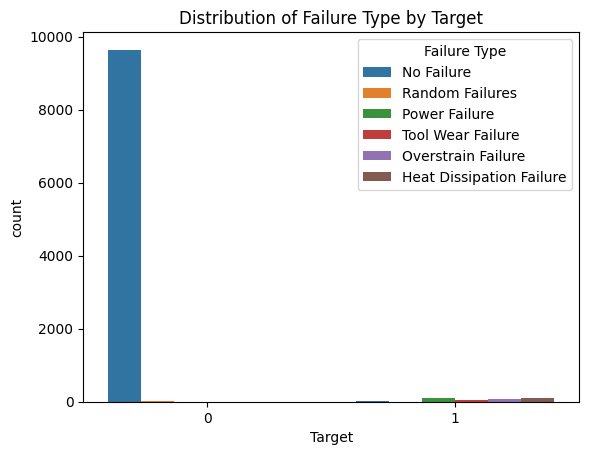

In [68]:
sns.countplot(data=df, x='Target', hue='Failure Type')
plt.title('Distribution of Failure Type by Target')
plt.show()

'No failure' is essentially the same thing as the target. It looks like there's a few weird inputs, so we might want to throw these out in model development.